# Satellite Image Classification

## Introduction
> In this project, a dataset of satellite images has been chosen for a multi-class
classification, classifying images of clouds, desert area, green area or water.

>The dataset consists of 5631 256x256 images, with classes already being split into four seperate files.

> A custom convolutional neural network(CNN) model, a custom CNN model with image augmentation applied in the training set,  a ResNet50 model, an Xception model and a Vgg16 model are implemented for classifying each image.

## Imports

In [4]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import csv
import numpy as np
from tensorflow.keras import utils, layers
import os
from sklearn import metrics
from sklearn.metrics import accuracy_score
# from keras.preprocessing.image import load_img,img_to_array
import keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16, Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## Upload dataset

In [5]:
#upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stamatiskal","key":"df278e9ecc996b3b3d51d4b6756bbe8a"}'}

In [6]:
# Make directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Download dataset, unzip and remove zip files
! kaggle datasets download 'mahmoudreda55/satellite-image-classification'
! mkdir satclass
! unzip satellite-image-classification.zip  -d satclass
! rm satellite-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: satclass/data/cloudy/train_23566.jpg  
  inflating: satclass/data/cloudy/train_23598.jpg  
  inflating: satclass/data/cloudy/train_23608.jpg  
  inflating: satclass/data/cloudy/train_23634.jpg  
  inflating: satclass/data/cloudy/train_23636.jpg  
  inflating: satclass/data/cloudy/train_23646.jpg  
  inflating: satclass/data/cloudy/train_2366.jpg  
  inflating: satclass/data/cloudy/train_23664.jpg  
  inflating: satclass/data/cloudy/train_23706.jpg  
  inflating: satclass/data/cloudy/train_2380.jpg  
  inflating: satclass/data/cloudy/train_23805.jpg  
  inflating: satclass/data/cloudy/train_23806.jpg  
  inflating: satclass/data/cloudy/train_23826.jpg  
  inflating: satclass/data/cloudy/train_23843.jpg  
  inflating: satclass/data/cloudy/train_23877.jpg  
  inflating: satclass/data/cloudy/train_23884.jpg  
  inflating: satclass/data/cloudy/train_23953.jpg  
  inflating: satclass/data/cloudy/train_2396.jpg  
  inflating: sat

## Data Visualisation

In [8]:
main_dir = '/content/satclass/data'

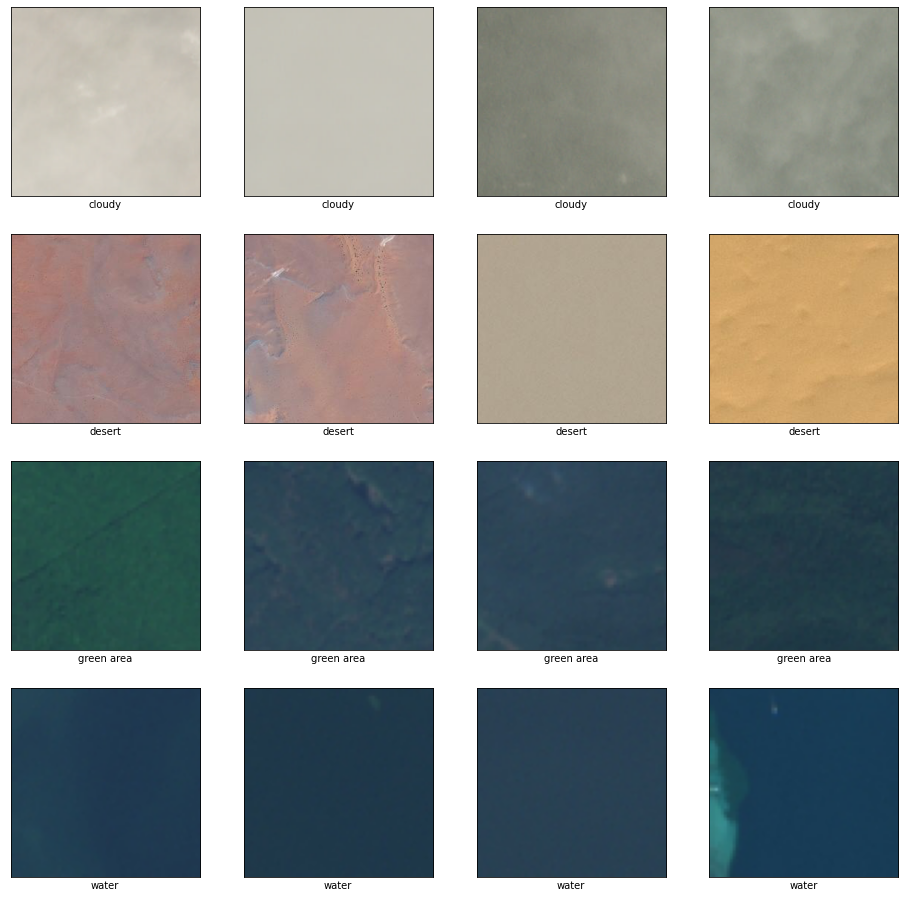

In [9]:
classes = [ 'cloudy', 'desert', 'green area', 'water' ]

cloudy_img = [im for im in os.listdir('/content/satclass/data/cloudy')
              if any(im.endswith(ext) for ext in ['jpg'])]
desert_img = [im for im in os.listdir('/content/satclass/data/desert')
              if any(im.endswith(ext) for ext in ['jpg'])]
greenarea_img = [im for im in os.listdir('/content/satclass/data/green_area')
              if any(im.endswith(ext) for ext in ['jpg'])]
water_img = [im for im in os.listdir('/content/satclass/data/water')
              if any(im.endswith(ext) for ext in ['jpg'])]
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    #clouds
    if i < 4:
      path = '/content/satclass/data/cloudy/' + cloudy_img[i]
      plt.xlabel(classes[0])
    #desert
    elif i<8:
      path = '/content/satclass/data/desert/'+ desert_img[i]
      plt.xlabel(classes[1])
    #green areas
    elif i<12:
      path = '/content/satclass/data/green_area/' + greenarea_img[i]
      plt.xlabel(classes[2])
    #water
    else:
      path = '/content/satclass/data/water/' + water_img[i]
      plt.xlabel(classes[3])
    img = plt.imread(path)
    plt.imshow(img)

## Resize dataset and split train, test and validation

In [10]:
def load_data(main_dir):
    images = []
    labels = []
    size = 128,128
    index = -1
    for folder in os.listdir(main_dir):
        index +=1
        for image in os.listdir(main_dir + "/" + folder):
            temp_img = cv2.imread(main_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(index)
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    labels = utils.to_categorical(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.25, random_state = 1)
    
    print('Loaded', len(x_train),'images for training, Train data shape =', x_train.shape)
    print('Loaded', len(x_test),'images for testing, Test data shape =', x_test.shape)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_data(main_dir)

Loaded 4223 images for training, Train data shape = (4223, 128, 128, 3)
Loaded 1408 images for testing, Test data shape = (1408, 128, 128, 3)


In [11]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.15, random_state = 1)
print('Loaded', len(x_val),'images for validation',', Validation data shape =', x_val.shape)

Loaded 634 images for validation , Validation data shape = (634, 128, 128, 3)


## Prediction function for test set

In [12]:
def predict(images, result, model):
  classes = ['cloudy', 'desert', 'green_area','water']
  c = 0
  for i in range(0,len(images)):
    im = images[[i]]
    y_prob = model.predict(im) 
    y_classes = y_prob.argmax(axis=1)
    results = result.argmax(axis=1)
    print('Prediction is: ', classes[y_classes[0]],'  Real result is: ',classes[results[i]])
    if  classes[y_classes[0]] != classes[results[i]]:
      print('Wrong prediction above')
      c +=  1
  print('Total of wrong predictions: ', c)
  return

## Confusion Matrix Function

In [ ]:
def conf_matrix(x_test, y_test,model):
  confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
  cm_display.plot()
  plt.title('Confusion Matrix')
  plt.show()

##Batch and epochs

In [13]:
numofclasses = 4
batch = 172
epochs = 100

## Custom model


In [14]:
custom_model = Sequential()

custom_model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))

custom_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
# custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
# custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
custom_model.add(Dropout(0.2))

custom_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
custom_model.add(BatchNormalization())
custom_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
custom_model.add(Dropout(0.5))

custom_model.add(Flatten())
custom_model.add(Dense(512 , activation = 'relu'))
custom_model.add(Dense(256 , activation = 'relu'))
# custom_model.add(Dense(256 , activation = 'relu'))
custom_model.add(Dense(numofclasses, activation = 'softmax'))

In [15]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
custom_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = custom_model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val, y_val), shuffle = True, verbose=1,
                    callbacks=[save_model])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.8050
Epoch 1: val_loss improved from inf to 1.37340, saving model to best_model.h5
21/21 [==============================] - 16s 211ms/step - loss: 0.5182 - accuracy: 0.8050 - val_loss: 1.3734 - val_accuracy: 0.2744
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9231
Epoch 2: val_loss did not improve from 1.37340
21/21 [==============================] - 2s 86ms/step - loss: 0.2038 - accuracy: 0.9231 - val_loss: 1.3868 - val_accuracy: 0.2744
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.1469 - accuracy: 0.9468
Epoch 3: val_loss did not improve from 1.37340
21/21 [==============================] - 2s 87ms/step - loss: 0.1469 - accuracy: 0.9468 - val_loss: 1.4433 - val_accuracy: 0.2744
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9521
Epoch 4: val_loss did not improve from 1.37340
21/21 [==

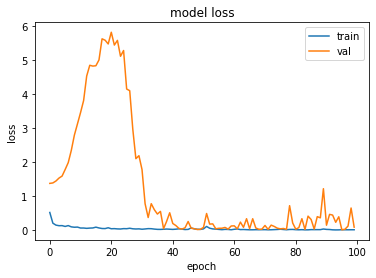

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

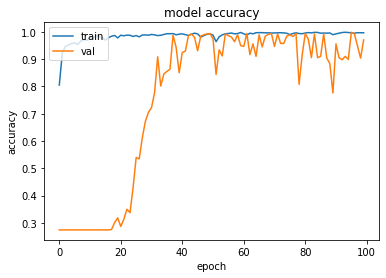

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
history.model.load_weights('best_model.h5')
print("Validation accuracy is: ", np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1)))

20/20 [==============================] - 1s 30ms/step
Validation accuracy is:  0.998422712933754


In [19]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

44/44 [==============================] - 0s 8ms/step


0.9957386363636364

44/44 [==============================] - 0s 7ms/step


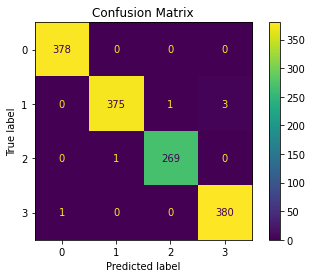

In [94]:
conf_matrix(x_test, y_test, custom_model)

In [56]:
predict(x_test, y_test, custom_model)

1/1 [==============================] - 0s 19ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 15ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 14ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 16ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 19ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 18ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 14ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 15ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 15ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  c

## Image Augmentation for custom model

In [57]:
datagen_model = Sequential()

datagen_model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,3)))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))

datagen_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
# datagen_model.add(Dropout(0.2))

datagen_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
# datagen_model.add(Dropout(0.2))

datagen_model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
# datagen_model.add(Dropout(0.2))

datagen_model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
datagen_model.add(Dropout(0.2))

datagen_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'valid'))
datagen_model.add(Dropout(0.5))

datagen_model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
datagen_model.add(Dropout(0.5))

datagen_model.add(Conv2D(1024 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
datagen_model.add(BatchNormalization())
datagen_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
datagen_model.add(Dropout(0.5))

datagen_model.add(Flatten())
datagen_model.add(Dense(512 , activation = 'relu'))
datagen_model.add(Dense(256 , activation = 'relu'))
# datagen_model.add(Dense(256 , activation = 'relu'))
datagen_model.add(Dense(numofclasses, activation = 'softmax'))
datagen = ImageDataGenerator( 
        vertical_flip=True,
        rotation_range=60,
        zoom_range = 0.2
        )
datagen.fit(x_train)

In [58]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
datagen_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = datagen_model.fit(datagen.flow(x_train, y_train, batch_size=batch), epochs=epochs, steps_per_epoch=x_train.shape[0] // batch, validation_data=(x_val, y_val), shuffle = True, verbose=1, 
                    callbacks=[save_model])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.6544
Epoch 1: val_loss improved from inf to 1.38322, saving model to best_model.h5
20/20 [==============================] - 17s 693ms/step - loss: 0.8490 - accuracy: 0.6544 - val_loss: 1.3832 - val_accuracy: 0.2587
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8777
Epoch 2: val_loss did not improve from 1.38322
20/20 [==============================] - 12s 620ms/step - loss: 0.3306 - accuracy: 0.8777 - val_loss: 1.3927 - val_accuracy: 0.2744
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.9061
Epoch 3: val_loss did not improve from 1.38322
20/20 [==============================] - 20s 993ms/step - loss: 0.2366 - accuracy: 0.9061 - val_loss: 1.4267 - val_accuracy: 0.2744
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9312
Epoch 4: val_loss did not improve from 1.38322
20/20

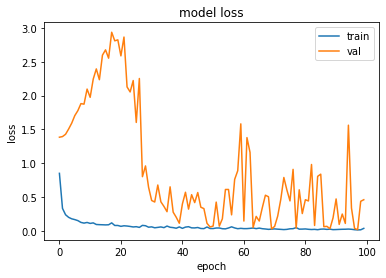

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

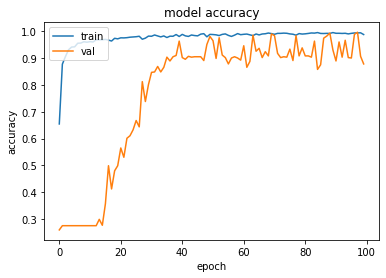

In [60]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1))

20/20 [==============================] - 0s 12ms/step


0.9968454258675079

In [62]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

44/44 [==============================] - 0s 10ms/step


0.9914772727272727

44/44 [==============================] - 0s 10ms/step


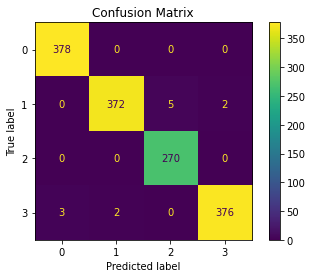

In [95]:
conf_matrix(x_test, y_test, datagen_model)

In [64]:
predict(x_test, y_test, datagen_model)

1/1 [==============================] - 0s 177ms/step
Prediction is:  cloudy   Real result is:  water
Wrong prediction above
1/1 [==============================] - 0s 21ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 16ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 20ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 16ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 19ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 17ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 17ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 17ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 18ms/step
Prediction is:  cl

## VGG16 model


In [65]:
vgg16_model = VGG16(
    input_shape=(128,128,3),
    weights = 'imagenet',
    include_top=False)

vgg16_model.trainable =  False

inputs = keras.Input(shape=(128,128,3))

x = vgg16_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(numofclasses, activation = 'softmax')(x)

vgg16_model = keras.Model(inputs,outputs)

58889256/58889256 [==============================] - 3s 0us/step


In [66]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = vgg16_model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val,y_val), shuffle = True, verbose=1,callbacks=[save_model])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.4035
Epoch 1: val_loss improved from inf to 1.34680, saving model to best_model.h5
21/21 [==============================] - 18s 649ms/step - loss: 1.3085 - accuracy: 0.4035 - val_loss: 1.3468 - val_accuracy: 0.3076
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.9974 - accuracy: 0.6943
Epoch 2: val_loss improved from 1.34680 to 1.31147, saving model to best_model.h5
21/21 [==============================] - 6s 304ms/step - loss: 0.9974 - accuracy: 0.6943 - val_loss: 1.3115 - val_accuracy: 0.2808
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.8206
Epoch 3: val_loss improved from 1.31147 to 1.30854, saving model to best_model.h5
21/21 [==============================] - 6s 304ms/step - loss: 0.6775 - accuracy: 0.8206 - val_loss: 1.3085 - val_accuracy: 0.2823
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.4518 - a

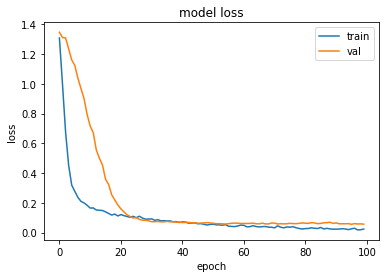

In [67]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

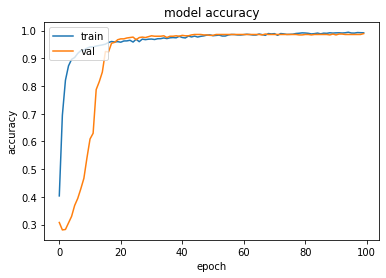

In [68]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [69]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1))

20/20 [==============================] - 4s 113ms/step


0.9858044164037855

In [70]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

44/44 [==============================] - 2s 49ms/step


0.9914772727272727

44/44 [==============================] - 2s 47ms/step


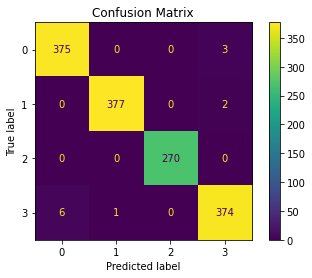

In [96]:
conf_matrix(x_test, y_test, vgg16_model)

In [72]:
predict(x_test, y_test, vgg16_model)

1/1 [==============================] - 1s 574ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 19ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 15ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 16ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 20ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 18ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 17ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  

## ResNet50 model

In [73]:
resnet50_model = ResNet50(
    input_shape=(128,128, 3),
    include_top=False)

resnet50_model.trainable =  False

inputs = keras.Input(shape=(128,128, 3))

x = resnet50_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(numofclasses, activation = 'softmax')(x)

resnet50_model = keras.Model(inputs,outputs)

94765736/94765736 [==============================] - 5s 0us/step


In [78]:
adam = Adam(learning_rate=0.001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
resnet50_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = resnet50_model.fit(x_train, y_train, batch_size=batch, epochs=100, validation_data=(x_val,y_val), shuffle = True, verbose=1, callbacks=[save_model])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8667 - accuracy: 0.5940
Epoch 1: val_loss improved from inf to 6.82066, saving model to best_model.h5
21/21 [==============================] - 15s 490ms/step - loss: 0.8667 - accuracy: 0.5940 - val_loss: 6.8207 - val_accuracy: 0.2744
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8440
Epoch 2: val_loss did not improve from 6.82066
21/21 [==============================] - 4s 210ms/step - loss: 0.3698 - accuracy: 0.8440 - val_loss: 14.6414 - val_accuracy: 0.2744
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2312 - accuracy: 0.9184
Epoch 3: val_loss did not improve from 6.82066
21/21 [==============================] - 4s 207ms/step - loss: 0.2312 - accuracy: 0.9184 - val_loss: 16.7405 - val_accuracy: 0.2744
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9468
Epoch 4: val_loss did not improve from 6.82066
21/21

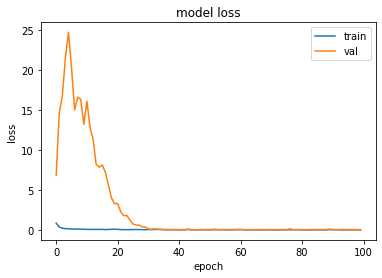

In [79]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

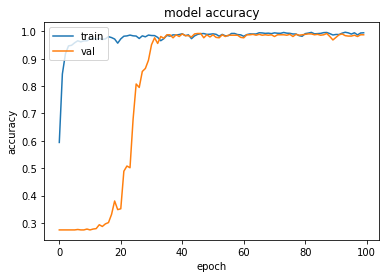

In [80]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [81]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1))

20/20 [==============================] - 2s 57ms/step


0.9921135646687698

In [82]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

44/44 [==============================] - 2s 37ms/step


0.9857954545454546

44/44 [==============================] - 2s 36ms/step


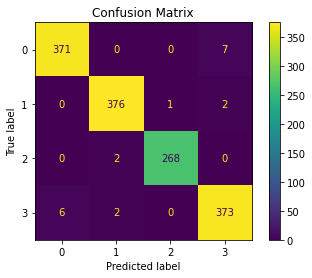

In [97]:
conf_matrix(x_test, y_test, resnet50_model)

In [84]:
predict(x_test, y_test, resnet50_model)

1/1 [==============================] - 0s 371ms/step
Prediction is:  cloudy   Real result is:  water
Wrong prediction above
1/1 [==============================] - 0s 26ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 26ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 20ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 20ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 22ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 22ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 21ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 21ms/step
Prediction is:  cl

## Xception model

In [85]:
xception_model = Xception(
    input_shape=(128,128, 3),
    include_top=False)

xception_model.trainable =  False

inputs = keras.Input(shape=(128, 128, 3))

x = xception_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(numofclasses, activation = 'softmax')(x)

xception_model = keras.Model(inputs,outputs)

83683744/83683744 [==============================] - 4s 0us/step


In [86]:
adam = Adam(learning_rate=0.0001)
save_model = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)
xception_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = xception_model.fit(x_train, y_train, batch_size=batch, epochs=epochs, validation_data=(x_val,y_val), shuffle = True, verbose=1,callbacks=[save_model])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.5043
Epoch 1: val_loss improved from inf to 1.32447, saving model to best_model.h5
21/21 [==============================] - 14s 469ms/step - loss: 1.2824 - accuracy: 0.5043 - val_loss: 1.3245 - val_accuracy: 0.6830
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.8539 - accuracy: 0.7398
Epoch 2: val_loss improved from 1.32447 to 1.26374, saving model to best_model.h5
21/21 [==============================] - 5s 258ms/step - loss: 0.8539 - accuracy: 0.7398 - val_loss: 1.2637 - val_accuracy: 0.8470
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.8306
Epoch 3: val_loss improved from 1.26374 to 1.19856, saving model to best_model.h5
21/21 [==============================] - 5s 259ms/step - loss: 0.6488 - accuracy: 0.8306 - val_loss: 1.1986 - val_accuracy: 0.8927
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss: 0.4954 - a

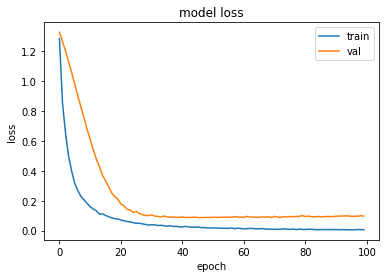

In [87]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

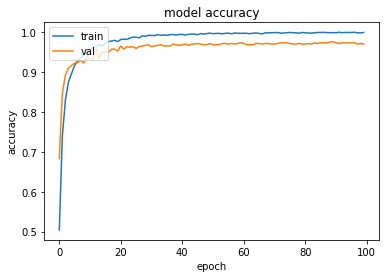

In [88]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_val),1)==np.argmax(y_val,1))

20/20 [==============================] - 2s 61ms/step


0.9716088328075709

In [90]:
history.model.load_weights('best_model.h5')
np.mean(np.argmax(history.model.predict(x_test),1)==np.argmax(y_test,1))

44/44 [==============================] - 2s 38ms/step


0.9694602272727273

44/44 [==============================] - 2s 40ms/step


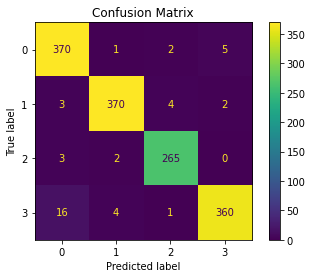

In [98]:
conf_matrix(x_test, y_test, xception_model)

In [92]:
predict(x_test, y_test, xception_model)

1/1 [==============================] - 0s 354ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 28ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 25ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 29ms/step
Prediction is:  water   Real result is:  water
1/1 [==============================] - 0s 39ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 26ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 31ms/step
Prediction is:  desert   Real result is:  desert
1/1 [==============================] - 0s 28ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 29ms/step
Prediction is:  cloudy   Real result is:  cloudy
1/1 [==============================] - 0s 19ms/step
Prediction is:  cloudy   Real result is:  

## Conclusion

Results | Custom model | Custom model Image Augmentation | VGG16 model|ResNet50 model | Xception model |
-|-|-|-|-|-|
Accuracy at Validation set | 0.998422712933754 | 0.9968454258675079 |0.9858044164037855 |  0.9921135646687698 | 0.9716088328075709
Mistakes made at test set (1408 images) | 6 | 12 | 12 | 20 | 43 |

>To summarize, the custom CNN model wth Image Augmentation scored the highest accuracy, but the least mistakes in the training set were made from the custom CNN model. 

>Transfer learning models also scored good accuracy, with VGG16 model scoring the highest accuracy among them (model.trainable set to False).